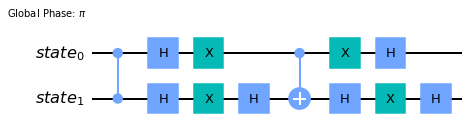

In [3]:
from qiskit import QuantumCircuit
from qiskit.algorithms import AmplificationProblem

# the state we desire to find is '11'
good_state = ['11']

# specify the oracle that marks the state '11' as a good solution
oracle = QuantumCircuit(2)
oracle.cz(0, 1)

# define Grover's algorithm
problem = AmplificationProblem(oracle, is_good_state=good_state)

# now we can have a look at the Grover operator that is used in running the algorithm
# (Algorithm circuits are wrapped in a gate to be appear in composition as a block
# so we have to decompose() the op to see it expanded into its component gates.)
problem.grover_operator.decompose().draw(output='mpl')

In [4]:
from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit.algorithms import Grover

aer_simulator = Aer.get_backend('aer_simulator')
grover = Grover(quantum_instance=aer_simulator)
result = grover.amplify(problem)
print('Result type:', type(result))
print()
print('Success!' if result.oracle_evaluation else 'Failure!')
print('Top measurement:', result.top_measurement)

Result type: <class 'qiskit.algorithms.amplitude_amplifiers.grover.GroverResult'>

Success!
Top measurement: 11


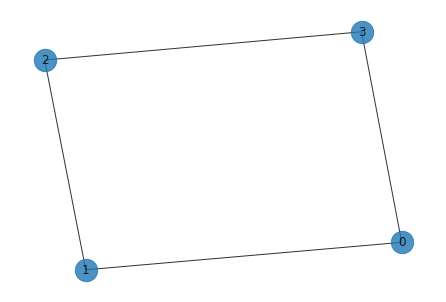

In [3]:
import networkx as nx

G = nx.Graph()
G.add_nodes_from([0, 1, 2, 3])
G.add_edges_from([(0, 1), (1, 2), (2, 3), (3, 0)])
nx.draw(G, with_labels=True, alpha=0.8, node_size=500)

In [6]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, execute
from qiskit.circuit import Parameter

# Adjacency is essentially a matrix which tells you which nodes are
# connected. This matrix is given as a sparse matrix, so we need to
# convert it to a dense matrix
adjacency = nx.adjacency_matrix(G).todense()

nqubits = 4

beta = Parameter("$\\beta$")
qc_mix = QuantumCircuit(nqubits)
for i in range(0, nqubits):
    qc_mix.rx(2 * beta, i)

qc_mix.draw()

/tmp/ipykernel_2738/3998253988.py:8: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency = nx.adjacency_matrix(G).todense()


┌───────────────┐
q_0: ┤ Rx(2*$\beta$) ├
     ├───────────────┤
q_1: ┤ Rx(2*$\beta$) ├
     ├───────────────┤
q_2: ┤ Rx(2*$\beta$) ├
     ├───────────────┤
q_3: ┤ Rx(2*$\beta$) ├
     └───────────────┘

In [7]:
gamma = Parameter("$\\gamma$")
qc_p = QuantumCircuit(nqubits)
for pair in list(G.edges()):  # pairs of nodes
    qc_p.rzz(2 * gamma, pair[0], pair[1])
    qc_p.barrier()
    
qc_p.decompose().draw()

░                              ░      »
q_0: ──■──────────────────────■───░───■──────────────────────■───░──────»
     ┌─┴─┐┌────────────────┐┌─┴─┐ ░   │                      │   ░      »
q_1: ┤ X ├┤ Rz(2*$\gamma$) ├┤ X ├─░───┼──────────────────────┼───░───■──»
     └───┘└────────────────┘└───┘ ░   │                      │   ░ ┌─┴─┐»
q_2: ─────────────────────────────░───┼──────────────────────┼───░─┤ X ├»
                                  ░ ┌─┴─┐┌────────────────┐┌─┴─┐ ░ └───┘»
q_3: ─────────────────────────────░─┤ X ├┤ Rz(2*$\gamma$) ├┤ X ├─░──────»
                                  ░ └───┘└────────────────┘└───┘ ░      »
«                             ░                              ░ 
«q_0: ────────────────────────░──────────────────────────────░─
«                             ░                              ░ 
«q_1: ────────────────────■───░──────────────────────────────░─
«     ┌────────────────┐┌─┴─┐ ░                              ░ 
«q_2: ┤ Rz(2*$\gamma$) ├┤ X ├─░───■──────────────────────■───░─
«     └────────────────┘└───┘ ░ ┌─┴─┐┌────────────────┐┌─┴─┐ ░ 
«q_3: ────────────────────────░─┤ X ├┤ Rz(2*$\gamma$) ├┤ X ├─░─
«                             ░ └───┘└────────────────┘└───┘ ░

In [9]:
qc_0 = QuantumCircuit(nqubits)
for i in range(0, nqubits):
    qc_0.h(i)
    
qc_0.draw()

┌───┐
q_0: ┤ H ├
     ├───┤
q_1: ┤ H ├
     ├───┤
q_2: ┤ H ├
     ├───┤
q_3: ┤ H ├
     └───┘

In [14]:
qc_qaoa = QuantumCircuit(nqubits)

qc_qaoa.append(qc_0, [i for i in range(0, nqubits)])
qc_qaoa.append(qc_p, [i for i in range(0, nqubits)])
qc_qaoa.append(qc_mix, [i for i in range(0, nqubits)])

qc_qaoa.decompose().decompose().draw()

┌─────────┐                             ░                              ░ »
q_0: ┤ U2(0,π) ├──■──────────────────────■───░───■──────────────────────■───░─»
     ├─────────┤┌─┴─┐┌────────────────┐┌─┴─┐ ░   │                      │   ░ »
q_1: ┤ U2(0,π) ├┤ X ├┤ Rz(2*$\gamma$) ├┤ X ├─░───┼──────────────────────┼───░─»
     ├─────────┤└───┘└────────────────┘└───┘ ░   │                      │   ░ »
q_2: ┤ U2(0,π) ├─────────────────────────────░───┼──────────────────────┼───░─»
     ├─────────┤                             ░ ┌─┴─┐┌────────────────┐┌─┴─┐ ░ »
q_3: ┤ U2(0,π) ├─────────────────────────────░─┤ X ├┤ Rz(2*$\gamma$) ├┤ X ├─░─»
     └─────────┘                             ░ └───┘└────────────────┘└───┘ ░ »
«                                  ░                              ░ »
«q_0: ─────────────────────────────░──────────────────────────────░─»
«                                  ░                              ░ »
«q_1: ──■──────────────────────■───░──────────────────────────────░─»
«     ┌─┴─┐┌────────────────┐┌─┴─┐ ░                              ░ »
«q_2: ┤ X ├┤ Rz(2*$\gamma$) ├┤ X ├─░───■──────────────────────■───░─»
«     └───┘└────────────────┘└───┘ ░ ┌─┴─┐┌────────────────┐┌─┴─┐ ░ »
«q_3: ─────────────────────────────░─┤ X ├┤ Rz(2*$\gamma$) ├┤ X ├─░─»
«                                  ░ └───┘└────────────────┘└───┘ ░ »
«     ┌────────────────┐
«q_0: ┤ R(2*$\beta$,0) ├
«     ├────────────────┤
«q_1: ┤ R(2*$\beta$,0) ├
«     ├────────────────┤
«q_2: ┤ R(2*$\beta$,0) ├
«     ├────────────────┤
«q_3: ┤ R(2*$\beta$,0) ├
«     └────────────────┘

In [11]:
def maxcut_obj(x, G):
    """
    Given a bitstring as a solution, this function returns
    the number of edges shared between the two partitions
    of the graph.
    
    Args:
        x: str
           solution bitstring
           
        G: networkx graph
        
    Returns:
        obj: float
             Objective
    """
    obj = 0
    for i, j in G.edges():
        if x[i] != x[j]:
            obj -= 1
            
    return obj


def compute_expectation(counts, G):
    
    """
    Computes expectation value based on measurement results
    
    Args:
        counts: dict
                key as bitstring, val as count
           
        G: networkx graph
        
    Returns:
        avg: float
             expectation value
    """
    
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        
        obj = maxcut_obj(bitstring, G)
        avg += obj * count
        sum_count += count
        
    return avg/sum_count


# We will also bring the different circuit components that
# build the qaoa circuit under a single function
def create_qaoa_circ(G, theta):
    
    """
    Creates a parametrized qaoa circuit
    
    Args:  
        G: networkx graph
        theta: list
               unitary parameters
                     
    Returns:
        qc: qiskit circuit
    """
    
    nqubits = len(G.nodes())
    p = len(theta)//2  # number of alternating unitaries
    qc = QuantumCircuit(nqubits)
    
    beta = theta[:p]
    gamma = theta[p:]
    
    # initial_state
    for i in range(0, nqubits):
        qc.h(i)
    
    for irep in range(0, p):
        
        # problem unitary
        for pair in list(G.edges()):
            qc.rzz(2 * gamma[irep], pair[0], pair[1])

        # mixer unitary
        for i in range(0, nqubits):
            qc.rx(2 * beta[irep], i)
            
    qc.measure_all()
        
    return qc

# Finally we write a function that executes the circuit on the chosen backend
def get_expectation(G, p, shots=512):
    
    """
    Runs parametrized circuit
    
    Args:
        G: networkx graph
        p: int,
           Number of repetitions of unitaries
    """
    
    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots
    
    def execute_circ(theta):
        
        qc = create_qaoa_circ(G, theta)
        counts = backend.run(qc, seed_simulator=10, 
                             nshots=512).result().get_counts()
        
        return compute_expectation(counts, G)
    
    return execute_circ

In [12]:
from scipy.optimize import minimize


expectation = get_expectation(G, p=1)

res = minimize(expectation, 
                      [1.0, 1.0], 
                      method='COBYLA')
res

     fun: -2.994140625
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 30
  status: 1
 success: True
       x: array([1.9793337 , 1.16663483])

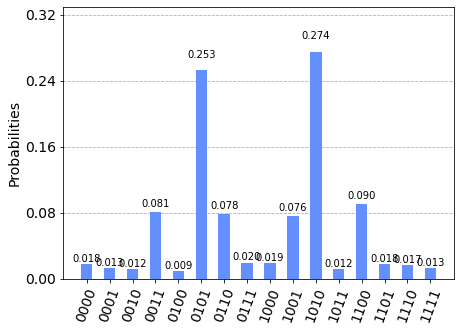

In [13]:
from qiskit.visualization import plot_histogram

backend = Aer.get_backend('aer_simulator')
backend.shots = 512

qc_res = create_qaoa_circ(G, res.x)

counts = backend.run(qc_res, seed_simulator=10).result().get_counts()

plot_histogram(counts)